In [1]:
import sys
sys.path.append('/home/victorialena/rlkit')

import pdb
import matplotlib.pyplot as plt
import rlkit
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric

from torch.optim import Adam
from torch_geometric.data import Data

from actor.collision_avoidance import *
from actor.actor_critic import *
from env.collision_avoidance import *
from replay_buffer import PPOBuffer

In [2]:
class Args():
    def __init__(self):
        self.seed = 0
        self.c_hidden = [64, 8]
        self.n_linear = 1
        self.eps = 0.1 
        self.sim_annealing_fac = 1.0 
        self.replay_buffer_cap = 10000
        self.n_samples = 10
        self.prioritized_replay = True
        self.learning_rate = 1E-4 #1E-3
        self.n_epoch = 100 
        self.n_iter = 128 
        self.batch_size = 64
        self.gamma = 0.99
        self.dropout = 0.05
        self.max_ep_len = 5000

        self.graph_type = "full" 
        self.load_from = ""
        self.save_to = ""
        self.plot = True
        self.plot_name = ""
        self.max_sample_distance = -1

        self.maze_size = 5 
        self.ndrones = 4
        self.ngoals = 0

In [10]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def _rot_b2i(X):
    abc = [rot_b2i(*x) for x in X]
    return torch.matmul(torch.stack(abc), torch.tensor([1.,0,0]))

def plot_path(obs, c_name='cividis'):
    cmap = cm.get_cmap(c_name)
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    # Data for a three-dimensional line
    obs = torch.stack([o.x[:, :3] for o in obs]).swapaxes(1,0) # shape (N, nd, 3)
    np.random.seed(42)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Trajectories')
    for _ in obs:
        xp, yp, zp = _.T
        ax.plot3D(xp, yp, zp, color=cmap(np.random.rand()))        
    return fig, ax

def plot_pos(obs, ax=None, saveas=""):
    if ax == None:
        ax = plt.axes(projection='3d')
    
    # Data for three-dimensional scattered points
    xp, yp, zp, _, _, _, v = obs.x.T
    u, v, w = _rot_b2i(obs.x[:, 3:-1]).T
    ax.scatter3D(xp, yp, zp)
    # ax.quiver(xp, y, z, u, v, w, length=1000, normalize=True)
    
    if saveas:
        plt.savefig("figs/collision_avoidance/"+saveas+".png", dpi=300)
    else:
        plt.show()
    return ax

In [4]:
args = Args()
device = 'cpu' #torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

env = collisionAvoidance(args, device=device)
x = env.reset()

In [5]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)
env.seed(args.seed)

``` python
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter 

def simple_animation(obs, saveas='collision_avoidance_1'):
    fig = plt.figure(figsize=(10,10))
    plot_path(obs)
    
    def env_simple_update(num, obs, ax):
        ax.clear()
        plot_pos(obs[num])
        ax.set_title("Frame {}".format(num))
    
    ani = animation.FuncAnimation(fig, env_simple_update, frames=len(obs), fargs=(obs, ax))
    ani.save("figs/drone_delivery/"+saveas+'.gif', writer='imagemagick', 
             savefig_kwargs={'facecolor':'white'}, fps=1)
```

In [6]:
def rollout(env, nsteps):
    o = env.reset()
    obs = [o]
    for _ in range(nsteps):
#         a = np.zeros((env.nagents, len(env.aspace.sample()))) 
        a = np.array([env.aspace.sample()/10 for _ in range(env.nagents)])
        next_o, _, _, _ = env.step(a)
        obs.append(next_o)
        o = next_o      
        
    return obs

In [7]:
obs = rollout(env, 2000)

```python
import cProfile, pstats, io
from pstats import SortKey
pr = cProfile.Profile()
pr.enable()

# ... do something ...
obs = rollout(env, 2000)

pr.disable()
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())
```

<Axes3DSubplot:title={'center':'Trajectories'}, xlabel='x', ylabel='y'>

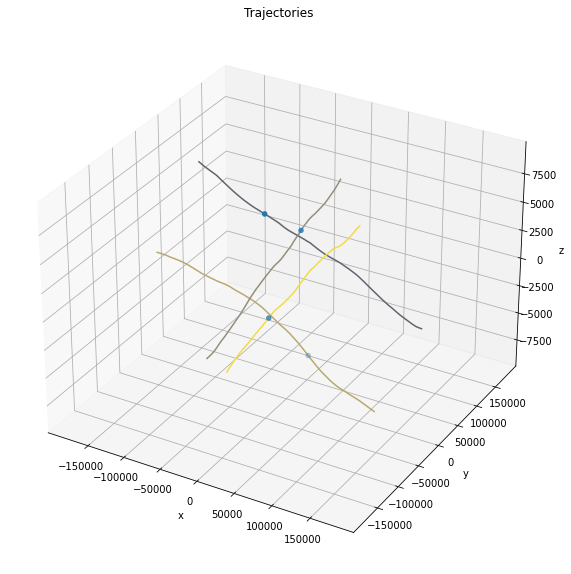

In [11]:
fig, ax = plot_path(obs)
plot_pos(obs[1400], ax)#, "example")

In [ ]:
plot_pos(obs[1200], ax)

In [ ]:
plt.show()

In [ ]:
for o in obs:
    print(o.x[:, :3])
    print("\n")

In [ ]:
obs[0].x[:, :3]

In [ ]:
in_channels, out_channels = env.get_channels()

qf_v = collisionAvoidanceModel(in_channels, 1, args.c_hidden, n_linear=args.n_linear, 
                               bounds=env.get_size(), dropout=args.dropout)

qf_pi = collisionAvoidanceModel(in_channels, out_channels, args.c_hidden, n_linear=args.n_linear, 
                                bounds=env.get_size(), dropout=args.dropout)

ac = MLPActorCritic(qf_pi, qf_v);

In [ ]:
torch.tensor([[env.config.maxXYZ//4, 0, 0, 0, 0, -np.pi, env.config.max_v],
              [0, env.config.maxXYZ//4, 0, 0, 0, -np.pi/2, env.config.max_v],
              [-env.config.maxXYZ//4, 0, 0, 0, 0, 0, env.config.max_v],
              [0, -env.config.maxXYZ//4, 0, 0, 0, np.pi/2, env.config.max_v]])

```python
lam=0.97
target_kl=0.01
clip_ratio=0.2
pi_lr=3e-4
vf_lr=1e-3
```

In [ ]:
def ppo(env, actor_critic, args, 
        lam=0.97, target_kl=0.01, clip_ratio=0.2, pi_lr=3e-4, vf_lr=1e-3):    
    """ Proximal Policy Optimization (by clipping), with early stopping based on approximate KL """

    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    env.seed(args.seed)

    def compute_loss_pi(data):
        obs, act, adv, logp_old = data['obs'], data['act'], data['adv'].unsqueeze(1), data['logp']
        act = act.reshape(-1, act.shape[-1])
        
        # Policy loss
        pi, logp = actor_critic.pi(obs, act)
        logp = logp.reshape(logp_old.shape)
        
        ratio = torch.exp(logp - logp_old)
        clip_adv = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * adv
        loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()

        # Useful extra info
        approx_kl = (logp_old - logp).mean().item()
        ent = pi.entropy().mean().item()
        clipped = ratio.gt(1+clip_ratio) | ratio.lt(1-clip_ratio)
        clipfrac = torch.as_tensor(clipped, dtype=torch.float32).mean().item()
        pi_info = dict(kl=approx_kl, ent=ent, cf=clipfrac)

        return loss_pi, pi_info

    def compute_loss_v(data):
        obs, ret = data['obs'], data['ret']
        return ((actor_critic.v(obs).sum(1) - ret)**2).mean()

    pi_optimizer = Adam(actor_critic.pi.parameters(), lr=pi_lr)
    vf_optimizer = Adam(actor_critic.v.parameters(), lr=vf_lr)

    def update():
        # TODO: should this be in the the training loop?
        data = buf.get()

        pi_l_old, pi_info_old = compute_loss_pi(data)
        pi_l_old = pi_l_old.item()
        v_l_old = compute_loss_v(data).item()

        # Train policy with multiple steps of gradient descent
        for i in range(args.n_iter):
            pi_optimizer.zero_grad()
            loss_pi, pi_info = compute_loss_pi(data)
            kl = pi_info['kl'] # mpi_avg(pi_info['kl'])
            if kl > 1.5 * target_kl:
                break # Early stopping at step %d due to reaching max kl
            loss_pi.backward()
            # mpi_avg_grads(actor_critic.pi)    # average grads across MPI processes
            pi_optimizer.step()

        # Value function learning
        for i in range(args.n_iter):
            vf_optimizer.zero_grad()
            loss_v = compute_loss_v(data)
            loss_v.backward()
            # mpi_avg_grads(actor_critic.v)    # average grads across MPI processes
            vf_optimizer.step()

        # Log changes from update
        # kl, ent, cf = pi_info['kl'], pi_info_old['ent'], pi_info['cf']
        return loss_pi.item(), loss_v.item()

    o, ep_ret, ep_len = env.reset(), 0, 0
    max_ep_len = args.max_ep_len
    buf = PPOBuffer(args.n_samples*max_ep_len, # args.replay_buffer_cap, 
                    args.gamma, lam)

    for epoch in range(args.n_epoch):        
        actor_critic.train(True)
        ret_train = []
        for t in range(args.n_samples*max_ep_len):
            if ep_len == 0:
                buf.start_path()
            a, v, logp = actor_critic.step(o)

            next_o, r, d, _ = env.step(a)
            ep_ret += r
            ep_len += 1

            # save and log
            buf.add_sample(o, a, r, v, logp)

            # Update obs (critical!)
            o = next_o

            timeout = ep_len == max_ep_len
            terminal = d or timeout
            epoch_ended = t == (args.n_samples*max_ep_len)-1

            if terminal or epoch_ended:
                ret_train.append(ep_ret)
                if epoch_ended and not(terminal):
                    print('Warning: trajectory cut off by epoch at %d steps.'%ep_len, flush=True)

                # if trajectory didn't reach terminal state, bootstrap value target
                if timeout or epoch_ended:
                    _, v, _ = actor_critic.step(o) 
                else:
                    v = 0
                buf.finish_path(v)
                o, ep_ret, ep_len = env.reset(), 0, 0


        # Perform PPO update!
        loss_pi, loss_v = update()

        # Print progress
        err = 8
        print("iter ", epoch+1, " -> loss (π): ", round(loss_pi, err), "(v): ", round(loss_v, err),
              "| rewards: (train) ", round(np.mean(ret_train), err))


In [ ]:
ppo(env, ac, args)